In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

In [31]:
# ==========================================
# CONFIGURATION
# ==========================================
# Folder containing your Raw/Forensic CSVs
INPUT_FOLDER = r'./data/taskdata_out' 
# The GeoJSON containing Field Boundaries (from Notebook 1)
#FIELD_BOUNDARIES_file = r'harvest_tasks.geojson'
#FIELD_BOUNDARIES = 
# Where to save the final file
OUTPUT_FILE = r'./data/taskdata_out/NORMALIZED_FIELD_DATA.csv'

# --- COLUMN MAPPING DICTIONARY ---
# Keys = Columns in your Input File
# Values = Standard names used by this script
COLUMN_MAPPING = {
    # --- Standard Forensic Columns (Default) ---
    'Latitude':     'Latitude',
    'Longitude':    'Longitude',
    'UTM_Easting':  'UTM_Easting',
    'UTM_Northing': 'UTM_Northing',
    'Speed':        'Speed',
    'Moisture':     'Moisture',
    'Yield_T_Ha':   'Yield_T_Ha',
    'Datetime':     'Datetime',
    'Crop':         'Crop',
    'GPS_Speed':    'GPS_Speed',
    'Density_kg_L': 'Density_kg_L',
    'Year':         'Year',  # If already present
}

In [35]:
# ==========================================
# 1. LOAD & VERIFY coloums
# ==========================================
print("Loading all CSV data files...")
all_files = glob.glob(os.path.join(INPUT_FOLDER, "*_DATASET.csv"))

df_list = []
for f in all_files:
    if "NORMALIZED" in f: continue
    print(f"  Reading: {os.path.basename(f)}")
    temp_df = pd.read_csv(f)
    temp_df['Source_File'] = os.path.basename(f)
    df_list.append(temp_df)

if not df_list:
    raise FileNotFoundError("No CSV files found.")

df = pd.concat(df_list, ignore_index=True)

# --- VERIFICATION LOGIC ---
print("\n--- CHECKING COLUMN COMPATIBILITY ---")
current_cols = set(df.columns)
rename_dict = {}
missing_required = []

# 1. Check if Dictionary matches File
print(f"File Columns: {sorted(list(current_cols))}")

for file_col, script_col in COLUMN_MAPPING.items():
    if file_col in current_cols:
        if file_col != script_col:
            rename_dict[file_col] = script_col
            print(f"  [MAP] Mapping '{file_col}' -> '{script_col}'")
        else:
            print(f"  [OK]  Found '{file_col}'")
    else:
        # It's okay if a mapping is missing, AS LONG AS the target script_col isn't missing
        pass

# 2. Apply Renaming
if rename_dict:
    df.rename(columns=rename_dict, inplace=True)
    current_cols = set(df.columns) # Update after rename

# 3. Verify Script Requirements
REQUIRED_FOR_SCRIPT = ['Latitude', 'Longitude', 'Yield_T_Ha']
for req in REQUIRED_FOR_SCRIPT:
    if req not in current_cols:
        missing_required.append(req)

if missing_required:
    print("\n" + "!"*60)
    print(" CRITICAL ERROR: INPUT FILE DOES NOT MATCH MAPPING DICT")
    print("!"*60)
    print(f"The script needs these columns: {REQUIRED_FOR_SCRIPT}")
    print(f"Your file is missing: {missing_required}")
    print("\nACTION REQUIRED:")
    print("1. Look at the 'File Columns' list printed above.")
    print("2. Update 'COLUMN_MAPPING' in the Configuration section.")
    print("   Example: 'Your_Lat_Column': 'Latitude'")
    raise KeyError("Column Mapping Failed. See error message above.")

print("\n[SUCCESS] Column mapping verified. Proceeding...")
# ==========================================
# 2. YEAR/DATE HANDLING
# ==========================================
# CRITICAL FIX: Force a standalone copy to silence SettingWithCopyWarning
df = df.copy()

print("\n--- PROCESSING INPUT ---")

# A. Try to find a Date Column
if 'Datetime' in df.columns:
    df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
elif 'Task_Start' in df.columns:
    df['Datetime'] = pd.to_datetime(df['Task_Start'], errors='coerce')
else:
    print("Warning: No 'Datetime' column found. Attempting to generate from 'Time_ms'...")

# B. Extract Year
if 'Datetime' in df.columns:
    # Extract year (results in Floats because of NaNs)
    df['Year'] = df['Datetime'].dt.year
    
    # Fallback: If Year is still NaN (bad date), fill with a default or drop
    if df['Year'].isnull().any():
        bad_count = df['Year'].isnull().sum()
        print(f"  - Warning: {bad_count} rows have invalid dates.")
        
        # Drop rows and immediately COPY to ensure the result is clean
        df = df.dropna(subset=['Year']).copy()
        
    # FIX: Use direct assignment to change dtype (avoids FutureWarning)
    df['Year'] = df['Year'].astype(int)
else:
    # If the user provided a 'Year' column directly in the CSV
    if 'Year' in df.columns:
        print("  - Using pre-existing 'Year' column.")
        df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(0).astype(int)
    else:
        # Stop everything if we can't find a year
        raise ValueError("Could not determine Year. Please map a Date column in COLUMN_MAPPING.")

# --- FINAL STATS (PRETTY PRINT) ---
print("-" * 40)
print(f"Total Raw Points Loaded: {len(df):,}") # Adds comma separator (e.g., 134,542)

# Clean up Crops list
unique_crops = sorted(df['Crop'].unique().tolist())
print(f"Crops found: {', '.join(map(str, unique_crops))}")

# Clean up Years list
unique_years = sorted(df['Year'].unique().tolist())
print(f"Years found: {', '.join(map(str, unique_years))}")
print("-" * 40)

Loading all CSV data files...
  Reading: UNIVERSAL_ENRICHED_DATASET.csv

--- CHECKING COLUMN COMPATIBILITY ---
File Columns: ['Crop', 'Datetime', 'Density_kg_L', 'File', 'GPS_Speed', 'Gap_Bytes', 'Latitude', 'Longitude', 'Moisture', 'Packet_Type', 'Raw_Mass', 'Raw_Vol', 'Source_File', 'Speed', 'Status_Code', 'Yield_T_Ha']
  [OK]  Found 'Latitude'
  [OK]  Found 'Longitude'
  [OK]  Found 'Speed'
  [OK]  Found 'Moisture'
  [OK]  Found 'Yield_T_Ha'
  [OK]  Found 'Datetime'
  [OK]  Found 'Crop'
  [OK]  Found 'GPS_Speed'
  [OK]  Found 'Density_kg_L'

[SUCCESS] Column mapping verified. Proceeding...

--- PROCESSING INPUT ---
  - Warning: 113 rows have invalid dates.
----------------------------------------
Total Raw Points Loaded: 134,542
Crops found: HV - Hvede, RA - Raps / rybs, RG - Rajgræs, VB - Vårbyg, VIB - Vinterbyg
Years found: 2022, 2023, 2024, 2025
----------------------------------------



--- GENERATING HARVEST MAPS BY YEAR ---


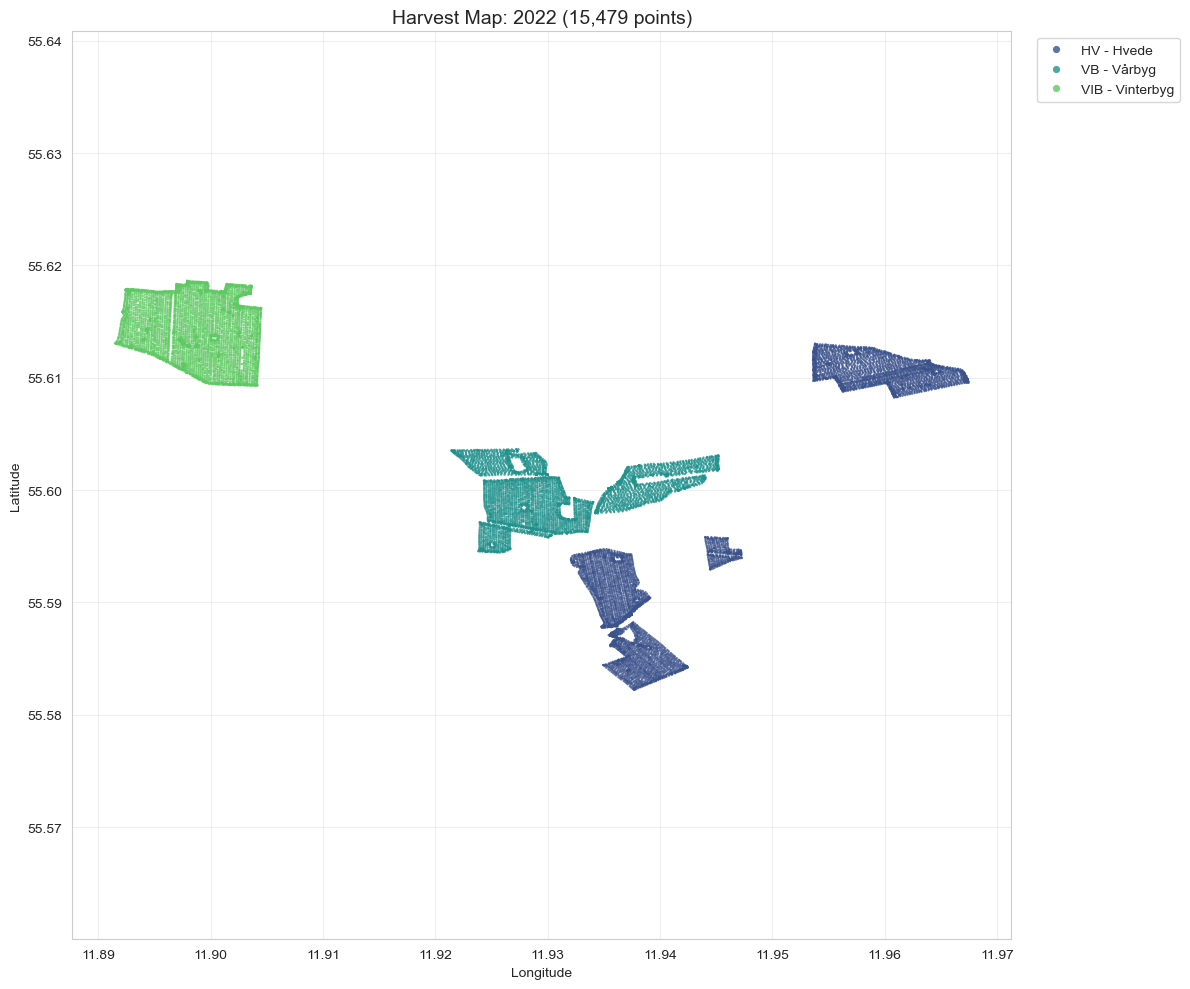

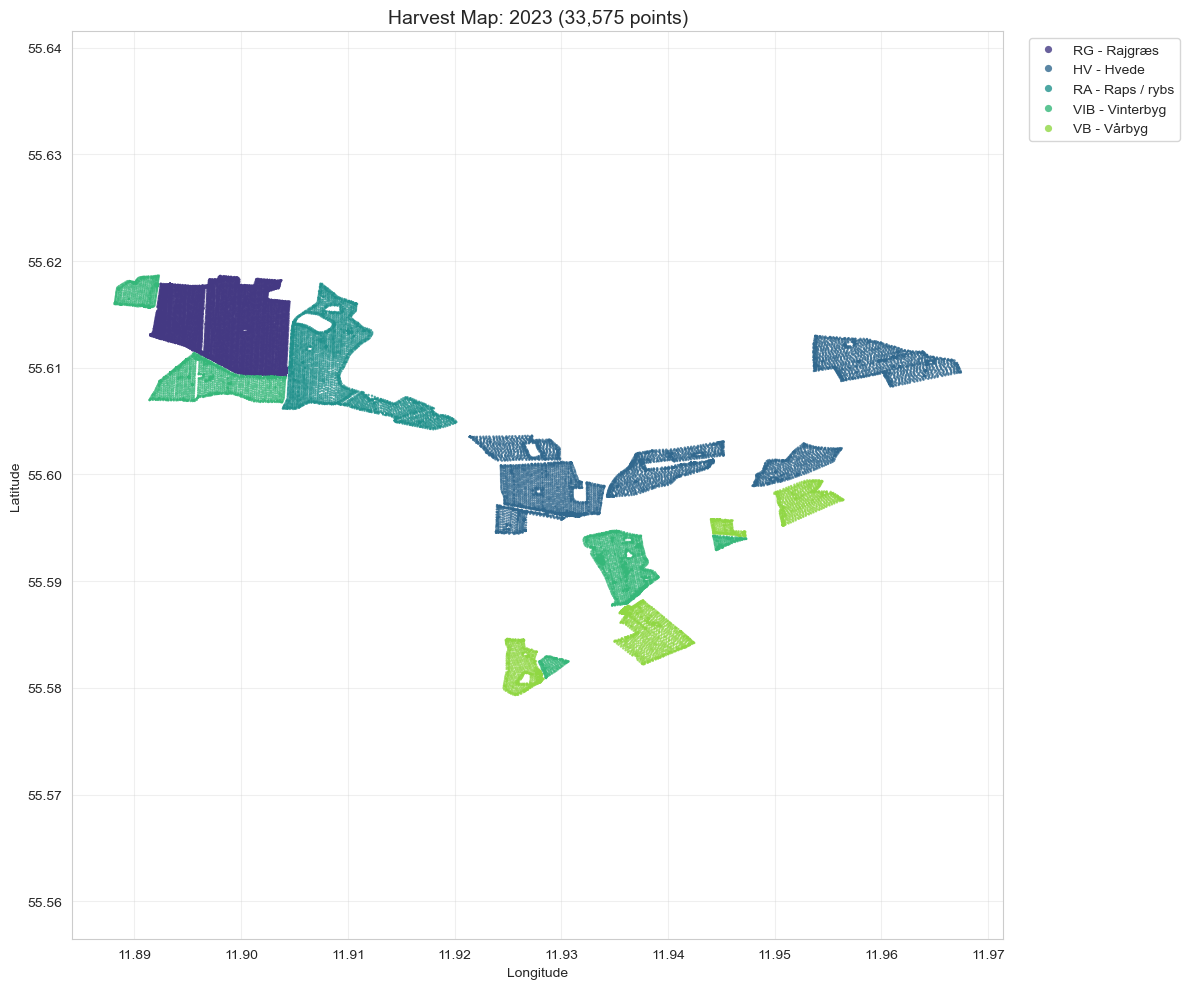

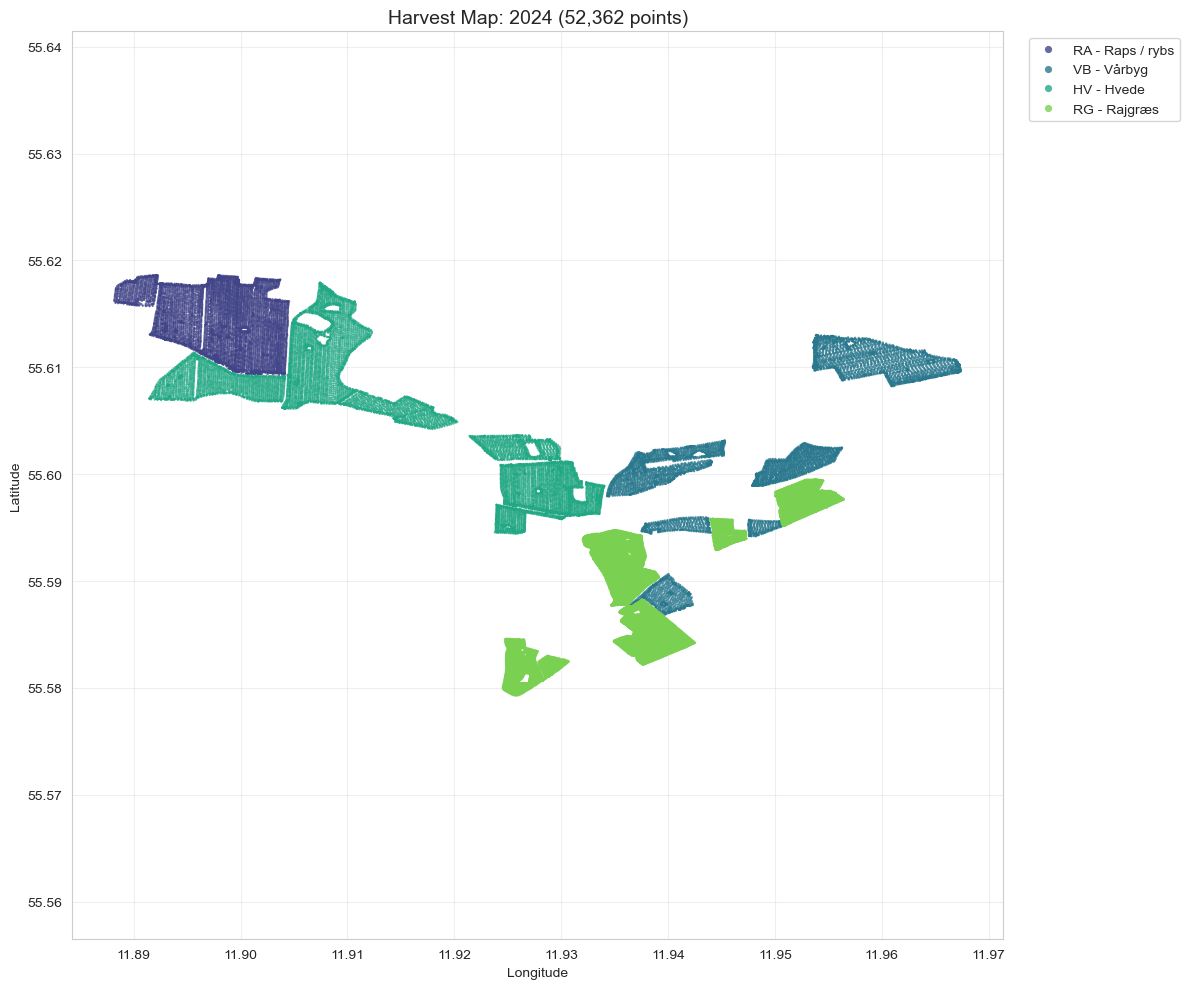

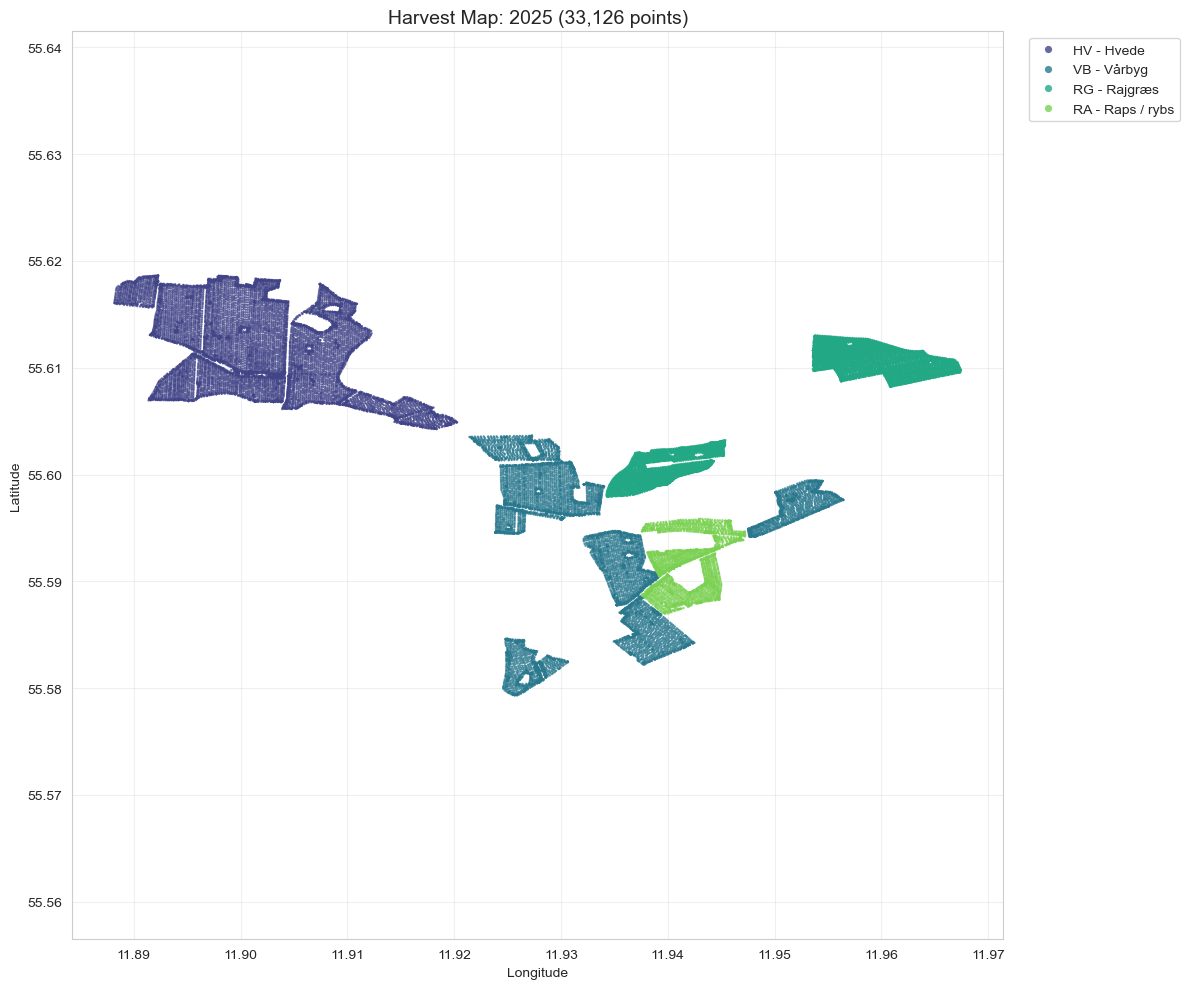

In [33]:
# ==========================================
# 3. SPATIAL VISUALIZATION (MAP BY YEAR)
# ==========================================
print("\n--- GENERATING HARVEST MAPS BY YEAR ---")
import matplotlib.pyplot as plt
import seaborn as sns

# Get list of years
unique_years = sorted(df['Year'].unique())

for year in unique_years:
    # Filter data for this year
    year_data = df[df['Year'] == year]
    
    # Skip if empty (e.g. if we dropped all data for a year)
    if year_data.empty: continue
    
    # Create Plot
    plt.figure(figsize=(12, 10))
    
    # Scatter Plot
    # s=2 -> Very small dots
    # linewidth=0 (or edgecolor='none') -> No border
    # alpha=0.6 -> Transparency helps see density
    sns.scatterplot(
        data=year_data,
        x='Longitude', 
        y='Latitude',
        hue='Crop',
        s=3, 
        linewidth=0,
        alpha=0.8,
        palette='viridis' # High contrast palette
    )
    
    # Formatting
    plt.title(f"Harvest Map: {year} ({len(year_data):,} points)", fontsize=14)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(markerscale=3, bbox_to_anchor=(1.02, 1), loc='upper left') # Bigger dots in legend
    plt.axis('equal') # Crucial for maps so they don't look stretched
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Show
    plt.show()


--- GENERATING NEUTRAL DIAGNOSTIC PLOTS ---


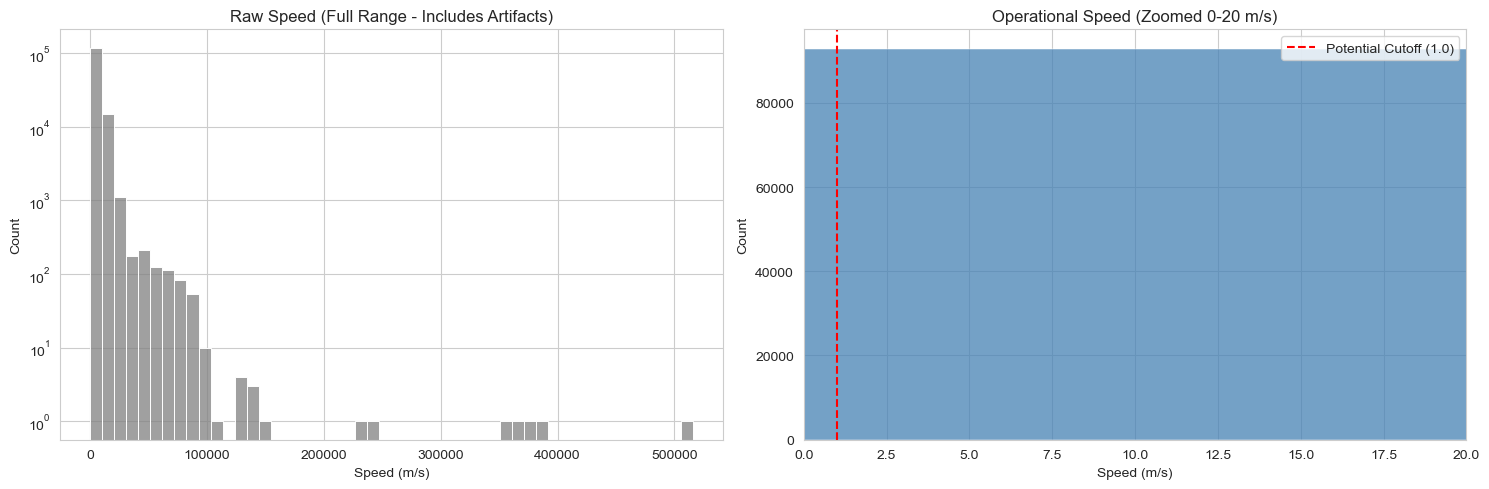

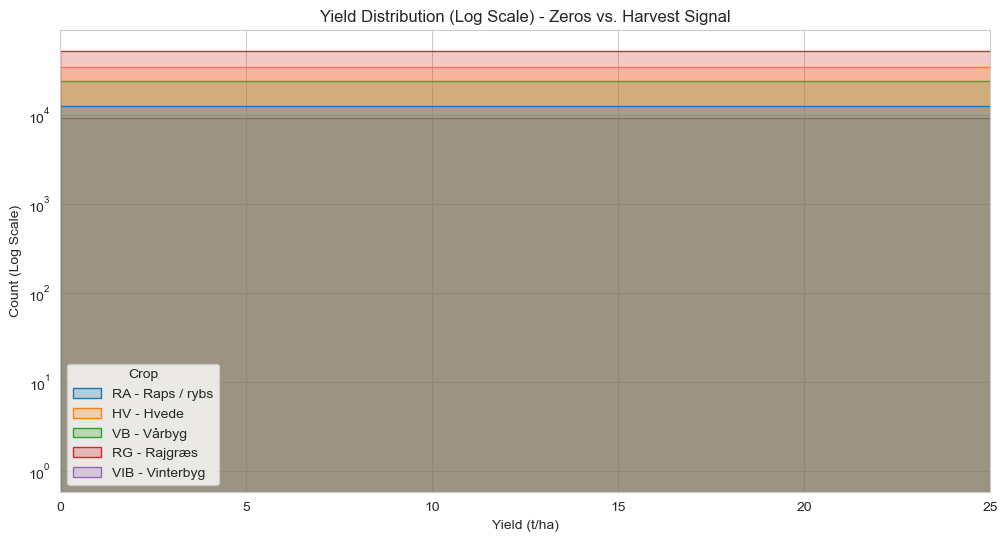

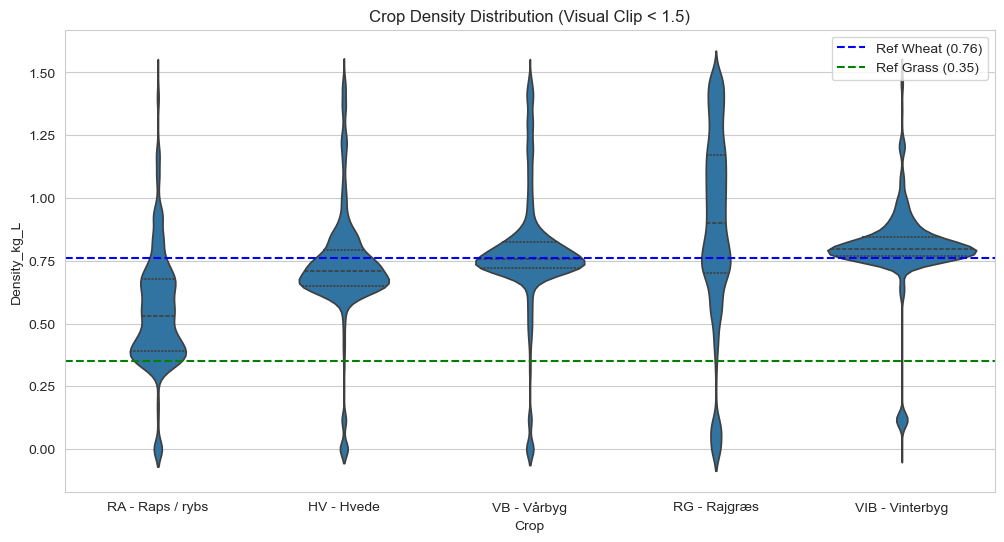


--- STATISTICAL COMPARISON (Help for choosing Thresholds) ---
Crop               | All Data Med | Non-Zero Med | Active 5%  | Active 95%
--------------------------------------------------------------------------------
HV - Hvede         | 0.00         | 0.03         | 0.01       | 7.91      
RA - Raps / rybs   | 0.00         | 0.03         | 0.01       | 45.36     
RG - Rajgræs       | 0.00         | 0.03         | 0.01       | 3.71      
VB - Vårbyg        | 0.00         | 0.03         | 0.01       | 1.44      
VIB - Vinterbyg    | 0.00         | 0.02         | 0.01       | 1.67      
--------------------------------------------------------------------------------
Use the 'Active 5%' and 'Active 95%' columns to set your MIN_YIELD and MAX_YIELD config.


In [36]:
# ==========================================
# 4. DIAGNOSTICS (EDA) - NEUTRAL / NO ASSUMPTIONS
# ==========================================
print("\n--- GENERATING NEUTRAL DIAGNOSTIC PLOTS ---")
sns.set_style("whitegrid")

# --- A. SPEED DISTRIBUTION (Full Range vs. Zoom) ---
# We show TWO plots: One for the artifacts (0-800), one for reality (0-20)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: The "Raw" Reality (Staircase Artifacts)
sns.histplot(df['GPS_Speed'], bins=50, ax=ax[0], color='gray')
ax[0].set_title("Raw Speed (Full Range - Includes Artifacts)")
ax[0].set_xlabel("Speed (m/s)")
ax[0].set_yscale('log') # Log scale helps see the tiny bars at 800 m/s

# Plot 2: The "Operational" View (Zoomed)
sns.histplot(df['GPS_Speed'], bins=100, ax=ax[1], color='steelblue')
ax[1].set_title("Operational Speed (Zoomed 0-20 m/s)")
ax[1].set_xlabel("Speed (m/s)")
ax[1].set_xlim(0, 20)
ax[1].axvline(1.0, color='red', linestyle='--', label='Potential Cutoff (1.0)')
ax[1].legend()

plt.tight_layout()
plt.show()

# --- B. YIELD DISTRIBUTION (Log Scale to reveal the Bell Curve) ---
# Since 50% of data is 0, a normal plot hides the harvest. 
# A Log-Scale Y-Axis reveals the "Active Harvest" distribution without filtering.
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Yield_T_Ha', hue='Crop', element="step", bins=100)
plt.yscale('log') # <--- KEY CHANGE: Makes the small harvest bars visible
plt.title("Yield Distribution (Log Scale) - Zeros vs. Harvest Signal")
plt.xlabel("Yield (t/ha)")
plt.ylabel("Count (Log Scale)")
plt.xlim(0, 25) # Focus on the relevant x-range, but keep all data
plt.show()

# --- C. DENSITY CHECK (Violin Plot) ---
if 'Density_kg_L' in df.columns:
    plt.figure(figsize=(12, 6))
    # We clip the VISUALIZATION range to 0-1.5 so the plot isn't squashed by errors,
    # but we do NOT filter the dataset itself.
    sns.violinplot(x='Crop', y='Density_kg_L', data=df[df['Density_kg_L'] < 1.5], inner="quartile")
    plt.axhline(0.76, color='blue', linestyle='--', label='Ref Wheat (0.76)')
    plt.axhline(0.35, color='green', linestyle='--', label='Ref Grass (0.35)')
    plt.title("Crop Density Distribution (Visual Clip < 1.5)")
    plt.legend()
    plt.show()

# --- D. COMPARATIVE STATS TABLE ---
# We calculate stats for "All Data" vs "Non-Zero Data" to help you choose filters.
print("\n--- STATISTICAL COMPARISON (Help for choosing Thresholds) ---")
print(f"{'Crop':<18} | {'All Data Med':<12} | {'Non-Zero Med':<12} | {'Active 5%':<10} | {'Active 95%':<10}")
print("-" * 80)

for crop, group in df.groupby('Crop'):
    if len(group) < 100: continue
    
    # 1. Stats on EVERYTHING (Pure raw)
    med_all = group['Yield_T_Ha'].median()
    
    # 2. Stats on Non-Zero (Yield > 0.01) - Just for comparison
    non_zero = group[group['Yield_T_Ha'] > 0.01]
    
    if not non_zero.empty:
        med_nz = non_zero['Yield_T_Ha'].median()
        p05 = non_zero['Yield_T_Ha'].quantile(0.05)
        p95 = non_zero['Yield_T_Ha'].quantile(0.95)
    else:
        med_nz, p05, p95 = 0, 0, 0
    
    print(f"{crop:<18} | {med_all:<12.2f} | {med_nz:<12.2f} | {p05:<10.2f} | {p95:<10.2f}")

print("-" * 80)
print("Use the 'Active 5%' and 'Active 95%' columns to set your MIN_YIELD and MAX_YIELD config.")

In [ ]:
# ==========================================
# 3. FILTER & PROCESS (USER INPUT SECTION)
# ==========================================
# >>> USER: ADJUST THESE VALUES BASED ON THE GRAPHS ABOVE <<<

FILTER_CONFIG = {
    # Speed: Remove points where machine is turning/stopped
    'MIN_SPEED_M_S': 1.0,  
    'MAX_SPEED_M_S': 15.0,

    # Yield: Remove start/stop spikes and idle noise
    'MIN_YIELD_T_HA': 0.5, 
    'MAX_YIELD_T_HA': 25.0, # Cap huge spikes

    # Physics: Valid Density Range (if column exists)
    'MIN_DENSITY': 0.25,
    'MAX_DENSITY': 1.10
}

print(f"\nApplying Filters: {FILTER_CONFIG}")

# Apply Filters
mask_speed = df['GPS_Speed'].between(FILTER_CONFIG['MIN_SPEED_M_S'], FILTER_CONFIG['MAX_SPEED_M_S'])
mask_yield = df['Yield_T_Ha'].between(FILTER_CONFIG['MIN_YIELD_T_HA'], FILTER_CONFIG['MAX_YIELD_T_HA'])

if 'Density_kg_L' in df.columns:
    mask_physics = df['Density_kg_L'].between(FILTER_CONFIG['MIN_DENSITY'], FILTER_CONFIG['MAX_DENSITY'])
else:
    mask_physics = True

df_clean = df[mask_speed & mask_yield & mask_physics].copy()

print(f"Rows dropped: {len(df) - len(df_clean)} ({(len(df) - len(df_clean))/len(df)*100:.1f}%)")
print(f"Remaining Clean Data: {len(df_clean)}")

# ==========================================
# 4. SPATIAL JOIN (ASSIGN FIELDS)
# ==========================================
print("\nLoading Field Boundaries...")
gdf_fields = gpd.read_file(FIELD_BOUNDARIES)
# Keep relevant columns only
gdf_fields = gdf_fields[['FieldName', 'geometry']].drop_duplicates(subset=['FieldName'])

print("Performing Spatial Join (Assigning Points to Fields)...")
# Convert Points to GeoDataFrame
gdf_points = gpd.GeoDataFrame(
    df_clean, geometry=gpd.points_from_xy(df_clean.Longitude, df_clean.Latitude), crs="EPSG:4326"
)

# Join (Inner join drops points that fall outside known fields)
gdf_joined = gpd.sjoin(gdf_points, gdf_fields, how="inner", predicate="within")

print(f"Points inside valid fields: {len(gdf_joined)}")

# ==========================================
# 5. NORMALIZE (RELATIVE YIELD)
# ==========================================
print("Calculating Relative Yield (Normalizing by Field & Year)...")

def calculate_normalization(group):
    # We use the MEDIAN as the "100% Performance" reference for that field/year
    # Median is robust against outliers; Mean is not.
    reference_yield = group['Yield_T_Ha'].median()
    
    if reference_yield > 0:
        group['Yield_Relative_Pct'] = (group['Yield_T_Ha'] / reference_yield) * 100
    else:
        group['Yield_Relative_Pct'] = 0
        
    group['Field_Reference_Yield'] = reference_yield
    return group

# Group by FieldName, Year, and Crop to ensure we compare apples to apples
gdf_norm = gdf_joined.groupby(['FieldName', 'Year', 'Crop']).apply(calculate_normalization)

# Final Sanity Filter on Relative Yield (Remove > 300% spikes)
gdf_final = gdf_norm[gdf_norm['Yield_Relative_Pct'].between(10, 300)].copy()

# ==========================================
# 6. SAVE OUTPUT
# ==========================================
# Save as CSV (Geometry columns can be large/messy in CSV, usually dropped or kept as XY)
save_cols = [
    'Datetime', 'Year', 'Crop', 'FieldName', 
    'Latitude', 'Longitude', 
    'Yield_T_Ha', 'Yield_Relative_Pct', 'Field_Reference_Yield',
    'GPS_Speed', 'Density_kg_L

## We need to be able to merge data from differant files